 This notebook is to calibrate SNe Ia and and calcualte H0 in wCDM.  

In [154]:
# Importing necessary libraries 
import sys
import numpy as np
import emcee
import astropy.io.fits as pyfits
import matplotlib.pylab as pl
import random,os
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
from astropy.io import ascii
import corner
import scipy.integrate as integrate


Defining computing resources

In [155]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

12 CPUs


In [156]:
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

Read files containing calibrators and distant SNe Ia. All files are at ../data/working/ directory

In [157]:
file = 'B_ceph_update3.csv' # change the filaname here if needed for other bands or for other calibrators
tab = ascii.read('../data/working/'+file)

Here we select sample from the original sample

In [158]:
# Excluding peculiar events
w = np.where((tab['sn']!='CSP14abk') &  (tab['sn']!='PTF13dyt') &  (tab['sn']!='PTF13dym') &  (tab['sn']!='PS1-13eao') & (tab['subtype']!='Ia-SC') & (tab['subtype']!='Ia-02cx') & (tab['sn']!='1981B') & (tab['sn']!='SN2012fr') & (tab['sn']!='1991T'))

# Excluding peculiar events + 91T and 91bg
#w = np.where((tab['sn']!='CSP14abk') &  (tab['sn']!='PTF13dyt') &  (tab['sn']!='PTF13dym') &  (tab['sn']!='PS1-13eao') & (tab['subtype']!='Ia-91T')& (tab['subtype']!='Ia-91bg'))


Reading all parameters from the input file and marking distance hosts.

In [159]:
# LC and host
st = tab['st'][w]
est = tab['est'][w]
zhel = tab['zhel'][w]
zcmb = tab['zcmb'][w]
mmax = tab['Mmax'][w]
emmax = tab['eMmax'][w]
bv =tab['BV'][w]
ebv = tab['eBV'][w]
m_csp = tab['m'][w]
eml = (tab['m'][w]-tab['ml'][w])
emu = (tab['mu'][w]-tab['m'][w])
em = (emu+eml)/2.

dist = tab['dist'][w]
edist = tab['edist'][w]
c_ms = tab['covMs'][w]
c_mbv = tab['covBV_M'][w]
sn = tab['sn'][w]
cal = tab['caltype'][w]

Ho_dists = (dist < 0)
#Ho_dists = (cal =='s')
#print (file, len(st), len(st[Ho_dists]))

ss= np.where(dist>0)
print (np.min(zcmb), len(st[ss]))

0.0012072 24


In [160]:
#initial guess
plim=-19.3, -19.2
p1lim =-1.2,-1.1
p2lim=-.055,-0.05
rvlim =2.7,2.71
alphalim=-0.11,-0.1
siglim=0.1,.12
flim =0.7,0.71
#flim = 0.5,0.8
h0lim= 71.0,71.1
omegalim = 0.143,0.487

In [161]:
# The formulation is taken from  https://academic.oup.com/mnras/article/472/1/835/4002695

def timescape_distance_modulus(H0, z, f):
    # Constants
    
    c = 3e5  # Speed of light in km/s

    mu0 = 25+ (5 * np.log10(c*z/H0))
    
    up = (24 * (f**4)) - (23 * (f**3)) + (99 * (f**2) + 8)
    
    down = 2 * ((4*(f**2)) + f + 4)**2
    
    mu1 = (5/np.log(10)) * ((up/down)*z)   
    
    #up1 = (1984 * (f**8)) -()
    
    mu = mu0 + mu1
    return mu

In [162]:
# Liklihood function
c = 300000.
def like(par):
    p,p1,p2,rv,alpha,sig,f,h0 = par
    if  -25.0<p<14.0  and -10.0<p1<10.0 and -10.0<p2<10.0 and 0.<rv<10.0 and -1.<alpha<1. and 0.<sig<1. and  0.0<f<1.0 and  0.01< h0 < 1000.0: # priors
        
        
        #mu_obs = mmax - p - p1*(st - 1.) -  p2*(st - 1.)**2 - rv*bv - alpha*(m_csp-np.median(m_csp))
        mu_obs = mmax - p - p1*(st - 1.) -  p2*(st - 1.)**2 - rv*bv - (alpha*m_csp) # slope 

        
        mu_model = np.where(Ho_dists, timescape_distance_modulus(h0, zcmb, f), dist)
        

        fac= (p1+(2*p2*st))
        #velterm = (2.17*vel)**2/(c*zcmb)**2
        err = (fac*est)**2 +emmax**2 +(rv*ebv)**2+2*fac*c_ms+rv*c_mbv+sig**2 + (alpha*em)**2
        err1 = ((fac*est)**2) +(emmax**2) +((rv*ebv)**2)+(2*fac*c_ms)+(rv*c_mbv)+sig**2+(edist**2)+(alpha*em)**2#
    
        mu_stat = np.where(Ho_dists,err,err1)

      
        mu_stat=np.sqrt(mu_stat)
        dmu=mu_obs-mu_model
        
        chi =np.sum((dmu)**2/mu_stat**2)
        return -0.5*chi - (0.5*np.sum(np.log(2*np.pi*(mu_stat)**2))) 
    else:
        return -np.inf

In [163]:
# EMCEE
ndim, nwalkers = 8, 80
ssize=500
burnin = 200


p00 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p10 = np.random.rand(nwalkers) * (p1lim[1] - p1lim[0]) + p1lim[0]
p20 = np.random.rand(nwalkers) * (p2lim[1] - p2lim[0]) + p2lim[0]
rv0 = np.random.rand(nwalkers) * (rvlim[1] - rvlim[0]) + rvlim[0]
alpha0 = np.random.rand(nwalkers) * (alphalim[1] - alphalim[0]) + alphalim[0]
sig0 = np.random.rand(nwalkers) * (siglim[1] - siglim[0]) + siglim[0]
f0 = np.random.rand(nwalkers) * (flim[1] - flim[0]) + flim[0]
h00 = np.random.rand(nwalkers) * (h0lim[1] - h0lim[0]) + h0lim[0]

#p0 = zip(*[p00,p10,p20,rv0,alpha0,sig0,vel0,h00])
p0 = np.array([p00,p10,p20,rv0,alpha0,sig0,f0,h00]).T

In [164]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, like)
print ("running mcmc on "+file)
start = time.time()
sampler.run_mcmc(p0,ssize,progress=True)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
end = time.time()
serial_time = end - start

running mcmc on B_ceph_update3.csv


100%|██████████| 500/500 [00:35<00:00, 13.93it/s]


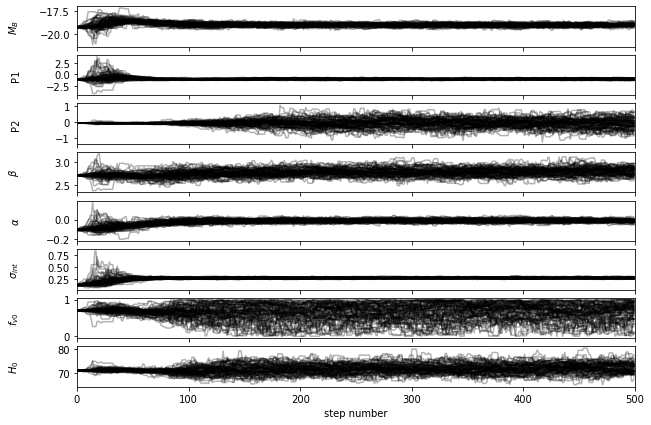

In [165]:
# Chains
fig, axes = pl.subplots(8, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$M_B$","P1", "P2", r"$\beta$",r"$\alpha$", r"$\sigma_{int}$",r"$f_{v0}$", r"$H_0$"]
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

#fig.savefig("../plots/steps_"+file[:-4]+"_"+str(nwalkers)+"_"+str(ssize)+".pdf")

samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))


In [166]:
# Printing results
p0_mcmc,p1_mcmc,p2_mcmc,rv_mcmc,alpha_mcmc,sig_mcmc,fv0_mcmc, H0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))


print("""MCMC result:
    P0 = {0[0]} +{0[1]} -{0[2]} 
    P1 = {1[0]} +{1[1]} -{1[2]} 
    P2 = {2[0]} +{2[1]} -{2[2]} 
    Beta = {3[0]} +{3[1]} -{3[2]}
    Alpha = {4[0]} +{4[1]} -{4[2]}
    Sigma = {5[0]} +{5[1]} -{5[2]}
    fv0 = {6[0]} +{6[1]} -{6[2]}
    H0 = {7[0]} +{7[1]} -{7[2]}

   
""".format(p0_mcmc, p1_mcmc, p2_mcmc,rv_mcmc,alpha_mcmc,sig_mcmc,fv0_mcmc, H0_mcmc))


MCMC result:
    P0 = -19.018773133802767 +0.16863504333411328 -0.16374005703579186 
    P1 = -0.982805279569509 +0.11212389573493753 -0.11601954939402792 
    P2 = -0.04918733883648202 +0.28304784797279386 -0.3021586783138889 
    Beta = 2.7863415792645685 +0.0845948396621714 -0.08235342852233574
    Alpha = -0.01085818344898421 +0.015384997270419075 -0.015953575771818156
    Sigma = 0.2641021267632354 +0.01230916450016345 -0.011453417968933122
    fv0 = 0.6995567762573922 +0.20374426359531816 -0.2826496221910259
    H0 = 71.73062966303759 +2.1187059802507378 -1.990458424791285

   



Mean acceptance fraction: 0.43965000000000004
Serial took 0.6 minutes


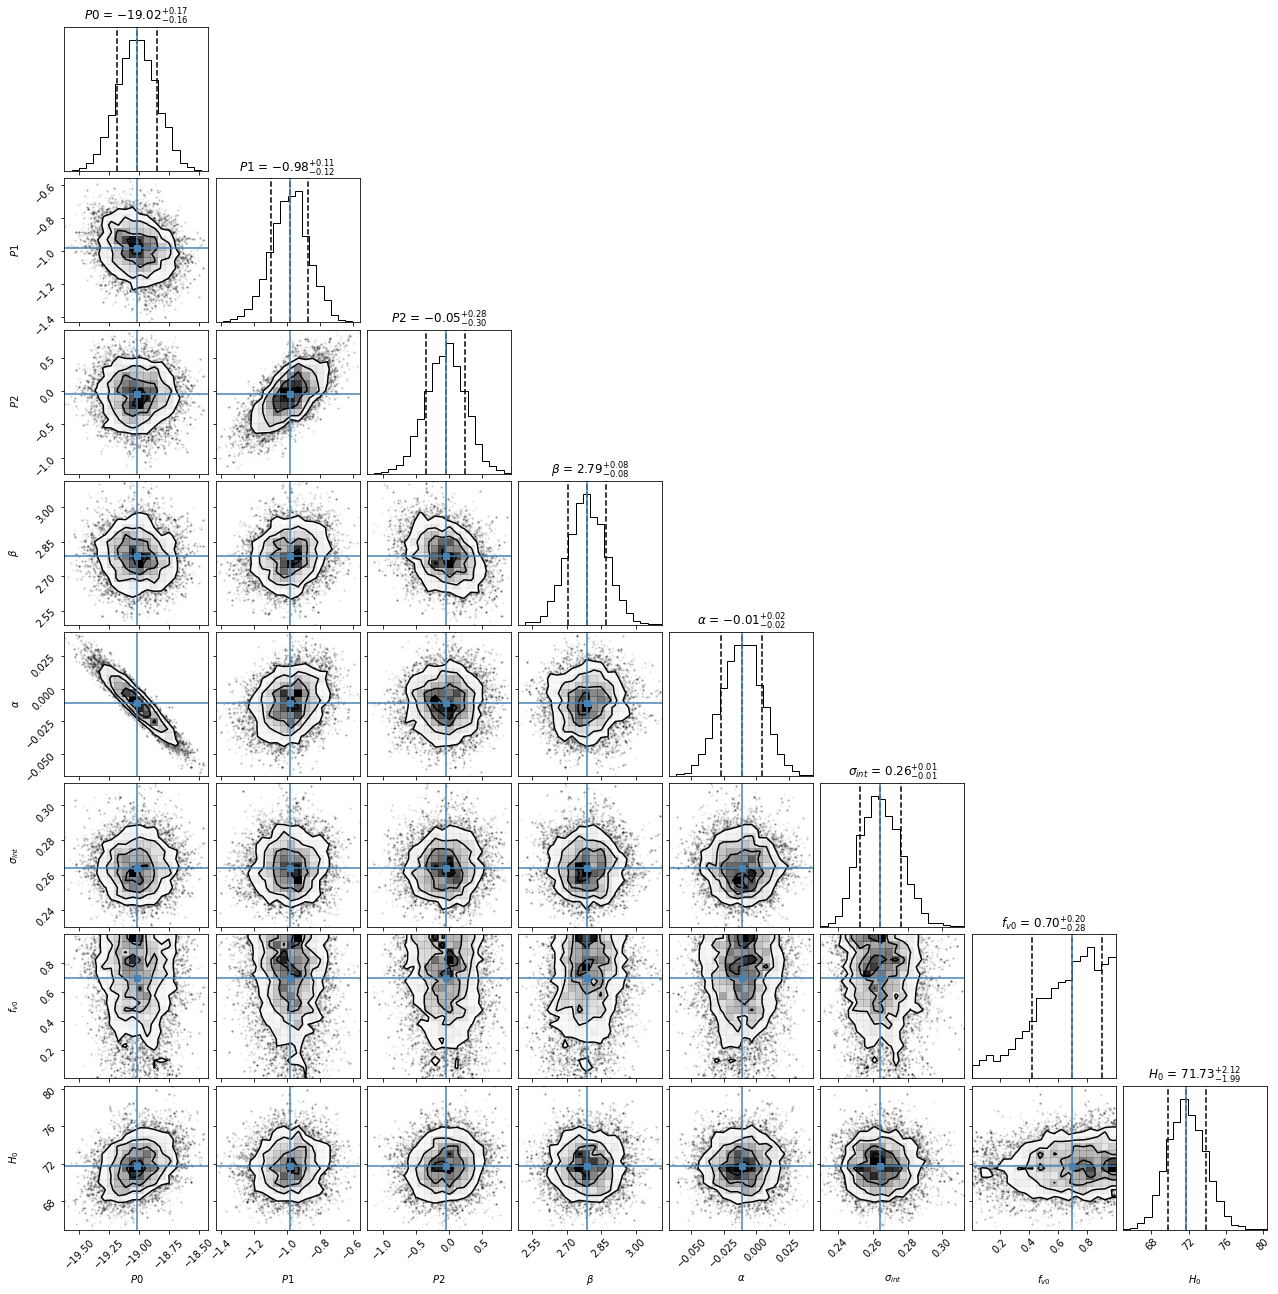

In [167]:
print ("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

# Corner plot
figure = corner.corner(samples,labels=["$P0$","$P1$", "$P2$", r"$\beta$",r"$\alpha$", r"$\sigma_{int}$","$f_{v0}$", r"$H_0$"],quantiles=[0.16, 0.5, 0.84],truths=[p0_mcmc[0],p1_mcmc[0],p2_mcmc[0],rv_mcmc[0],alpha_mcmc[0],sig_mcmc[0],fv0_mcmc[0],H0_mcmc[0]],show_titles=True)

print("Serial took {0:.1f} minutes".format(serial_time/60.))